# RQ3 (Self-containedness)

> Is the behaviour of unsafe code dependent only on code in its own crate?

We considered two queries to answer this question.

## Query 4

> we use a refined query that counts *how many function calls in unsafe blocks have a call target which is located in (1) its own crate, (2) a crate belonging to the standard library, (3) a -sys crate, or (4) any other crate*.

We distinguish two cases for this query:

1. All standard function calls in unsafe blocks
2. Only calls of unsafe functions in unsafe blocks

## Query 5

> *we measure how many function calls in unsafe blocks and unsafe functions are (a) standard function calls, (b) calls of trait methods, or (c) calls of closures or function pointers*.

We distinguish between two cases for this query:

1. The distribution of calls in unsafe blocks.
2. The distribution of calls in the entire dataset.

We first compute the results of individual items separately and do some follow-ups by manual inspections based on 100 randomly selected calls.
The overall results of both queries as presented in the paper are found further below and are marked accordingly.

## Setup

In [49]:
# Load libraries

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import top_crates
from whitelists import *

# Configure pyplot: enlarge plots
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pyplot: set larger font
plt.rcParams.update({'font.size': 40})
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)
# Font for paper
plt.rc('font', family='serif')

In [50]:
# Define output functions
def debug(template, *args, **kwargs):
    print(template.format(*args, **kwargs))
def info(template, *args, **kwargs):
    print(template.format(*args, **kwargs))

In [51]:
# Load tables
unsafe_block_calls = utils.load_unsafe_thir_block_calls_extended()

In [52]:
# Validation
assert len(unsafe_block_calls.query("crate_name == target_crate and build_crate_hash == target_crate_hash")) > 0
assert len(unsafe_block_calls.query("not (crate_name == target_crate and build_crate_hash == target_crate_hash)")) > 0

In [53]:
# We are interested only in the user-written unsafe blocks.
unsafe_block_calls = unsafe_block_calls.query('check_mode != "UnsafeBlockCompilerGenerated"')
assert len(pd.unique(unsafe_block_calls['check_mode'])) == 1

In [54]:
# Whitelists
all_crate_names = (
    set(unsafe_block_calls.crate_name.unique())
    | set(unsafe_block_calls.target_crate.unique())
)
all_function_names = unsafe_block_calls.call_target_def_path.unique()

sys_crate_names = get_sys_crate_names(all_crate_names)
unchecked_function_names = get_unchecked_function_names(all_function_names)

# Validation
assert "std" in all_crate_names

In [55]:
print("Number of calls in unsafe blocks:", len(unsafe_block_calls))

Number of calls in unsafe blocks: 11549


In [56]:
# Niels cell for diffing old and new
# 

print(unsafe_block_calls[~unsafe_block_calls['crate_name'].isin(["std", "core", "alloc", "proc_macro"])].__len__())

# find the function summary path containing the call itself, i.e., unsafe_block_calls['block']
niels_unsafe_thir_blocks = utils.load_unsafe_thir_blocks()

niels_unsafe_block_calls_join = unsafe_block_calls.join(niels_unsafe_thir_blocks[['block', 'summary_key']].set_index('block'), on='block', how='left')

# write to _new
niels_unsafe_block_calls_join.to_csv('niels_unsafe_block_calls_no_std_new.csv', index=False, columns=['summary_key', 'call_target_summary_key'])

# parse from 'niels_unsafe_block_calls_old.csv' 
# niels_unsafe_block_calls_old = pd.read_csv('niels_unsafe_block_calls_old.csv')

# # take symmetric difference on columns 'summary_key' and 'call_target_summary_key'
# cols = ['summary_key', 'call_target_summary_key'] 
# niels_unsafe_block_calls_diff = niels_unsafe_block_calls_join[cols].merge(niels_unsafe_block_calls_old[cols], how='outer', indicator=True)
# niels_unsafe_block_calls_diff.query('_merge != "both"')


1929


### Setup for follow-ups

We group calls into three groups based on the information available at the call site:

1.  **Function pointers and closures:** the programmer needs to manually
    trace down the origin of the function pointer or closure to be able
    to validate the call.
2.  **Trait methods:** the programmer knows which trait is used and,
    therefore, can rely on its documentation, but may not know which
    method exactly is going to be called.
3.  **Standard function calls:** the programmer knows precisely which
    implementation is going to be called.

For our follow ups, we manually inspect 100 randomly selected calls to the first and second
group to get insights into them and do additional automatic
categorization of the third group. We distinguish four categories of
calls from the “standard function calls” group based on the call target:

1.  Calls to functions defined in the same crate. Calls to such
    functions can be trusted more than calls to external crates
    because they are under full control of the developer.
2.  Calls to functions defined in so-called `-sys` crates. In Rust
    community, when writing safe Rust bindings to a library written in a
    different language (typically C), it is a common pattern to put the
    raw bindings in a separate crate that typically has `-sys` suffix in
    its name. This convention is in a direct conflict with the
    self-containedness property and, therefore, we separate out the
    calls to functions defined in `-sys` crates.
3.  Calls to the Rust standard library crates (`std`, `core`, `alloc`, and `proc_macro`). Since these libraries are maintained by the Rust
    compiler team in the same repository as the Rust compiler and
    guarantees of their functions are clearly documented, it is much
    easier to review calls to them.
4.  Calls to all other functions.

In [57]:
# Randomly select 100 calls and write them to the CSV file.
# To ensure that our random selection is not skewed by
# large crates, we first select a build and then select a
# call in it.
def generate_random_selection(calls, file_name):
    import secrets
    rows = []
    all_builds = list(pd.unique(calls['build']))
    for _ in range(100):
        build = secrets.choice(all_builds)
        build_calls = calls.query('build == @build')
        index = secrets.randbelow(len(build_calls))
        row = build_calls.iloc[[index]]
        rows.append(row)
    selected_rows = pd.concat(rows)
    selected_rows.to_csv(file_name)
def show_non_reviewed(file_name):
    calls = pd.read_csv(file_name)
    counter = 20
    for row in calls.iterrows():
        values = row[1]
        if not pd.isnull(values['reviewed']) and values['reviewed']:
            continue
        is_std = False
        path = values['file_name']
        if path.startswith('/opt/rustwide'):
            path = path[66:].split('/', 1)[1]
        if '.rustup/toolchains/nightly' in path:
            path = path.split('unknown-linux-gnu/lib/rustlib/src/rust/src/lib')[1]
            is_std = True
        path = path.replace('src/', '')
        
        info("===== {} {} ====", values['package_name'], values['package_version'])
        if is_std:
            info('https://doc.rust-lang.org/src/{}.html#{}', path, values['line'])
        else:
            info("https://crates.io/crates/{}", values['package_name'])
            info("https://docs.rs/{}/{}/", values['package_name'], values['package_version'])
            info("https://docs.rs/{}/{}/src/{}/{}.html#{}",
                 values['package_name'], values['package_version'],
                 values['crate_name'], path, values['line'])
        
        if counter == 0:
            break
        counter -= 1
    return calls

## Query 5 (c)

> we measure how many function calls in unsafe blocks and unsafe functions are (a) standard function calls, (b) calls of trait methods, or *(c) calls of closures or function pointers*.

In [58]:
def get_group1(calls):
    
    # Function pointers show up as non-const calls in our dataset.
    function_pointers = calls.query('call_target_summary_key == "non-const"')
    debug("Number of calls to function pointers: {}", len(function_pointers))
    
    # We can recognize closures by their traits.
    fn = calls.query('call_target_summary_key == "core.ops.function.Fn.call"')
    debug("Number of calls to Fn closures: {}", len(fn))
    fn_mut = calls.query('call_target_summary_key == "core.ops.function.FnMut.call_mut"')
    debug("Number of calls to FnMut closures: {}", len(fn_mut))
    fn_once = calls.query('call_target_summary_key == "core.ops.function.FnOnce.call_once"')
    debug("Number of calls to FnOnce closures: {}", len(fn_once))
    closures = pd.concat([fn, fn_once, fn_mut])
    debug("Total number of calls to closures: {}", len(closures))
    assert len(closures) == len(fn) + len(fn_once) + len(fn_mut)
    
    # All calls in group1.
    group1 = pd.concat([function_pointers, closures])
    info("Total number of calls to function pointers and closures: {}", len(group1))
    
    return group1

In [59]:
# Randomly select 100 calls for the manual inspection
group1 = get_group1(unsafe_block_calls)
# generate_random_selection(group1, "rq3_group1.csv")

Number of calls to function pointers: 38
Number of calls to Fn closures: 1
Number of calls to FnMut closures: 46
Number of calls to FnOnce closures: 7
Total number of calls to closures: 54
Total number of calls to function pointers and closures: 92


In [60]:
# Niels cell for diffing
group1 = get_group1(niels_unsafe_block_calls_join)

Number of calls to function pointers: 38
Number of calls to Fn closures: 1
Number of calls to FnMut closures: 46
Number of calls to FnOnce closures: 7
Total number of calls to closures: 54
Total number of calls to function pointers and closures: 92


### Follow-up manual inspection

> To understand why the proportion of calls to closures and function pointers is larger in unsafe
blocks than in all code (3.7% vs. 0.7%), we manually looked into several examples and noticed three
main patterns. The first one is parameterising the behaviour of unsafe code with a closure that
is passed in as an argument to the safe wrapper. A typical example of this pattern is the sort_by
function on the primitive type slice, which takes a comparison function as an argument. The second
pattern is using function pointers to call functions from dynamically-loaded libraries, and the third
pattern is using function pointers to implement callbacks to foreign libraries.


Manually checked questions:

1. Is the closure/function pointer defined in the same function in which it is called? (Column: `locally_defined`)
2. Can the external client provide the closure/function pointer? (Column: `is_submittable_by_client`)

Observed typical use cases:
* Dynamically load library and get a pointer to a function defined in it.
* Store FFI callbacks in a struct.
* Provide predicates to generic algorithms. For example, `less_than` for sorting algorithms, `filter` for a filtering iterator.
* Register event callbacks.
* Allow the client code to provide a callback that construct a data structures.

Observed interesting use cases:
* `ffi_utils/src/callback.rs:46:8` and `smart-ptr/src/lib.rs:26:8` define traits on function pointer types to be able to uniformly handle different function pointers.
* `obfstr/src/lib.rs:153:2` use a function pointer to prevent inlining of a function.

Conclusions:
1. It is rarely the case that the closure/function pointer is defined in the same function in which it is called. (Found only 5 cases out of 100.)
2. It is quite often the case that the client code can pass in the closure/function pointer to be called. Interestingly, in two cases the function via which this can be done is marked as unsafe even though it contains no unsafe code.

In [61]:
# Niels: Skipping the review parts. commented out.
# group1_reviewed = show_non_reviewed('rq3_group1_reviewed.csv')
# len(group1_reviewed.query('is_submittable_by_client != "False"'))

## Query 5 (b)

> we measure how many function calls in unsafe blocks and unsafe functions are (a) standard function calls, *(b) calls of trait methods*, or (c) calls of closures or function pointers.

In [62]:
def get_group2(calls):
    group2 = calls.query('is_target_trait_item')
    
    # Filter out closures.
    group2 = group2.query('call_target_summary_key != "core.ops.function.Fn.call"')
    group2 = group2.query('call_target_summary_key != "core.ops.function.FnMut.call_mut"')
    group2 = group2.query('call_target_summary_key != "core.ops.function.FnOnce.call_once"')

    info("Number of calls to trait methods: {}", len(group2))
    return group2

In [63]:
# Randomly select 100 calls for the manual inspection
group2 = get_group2(unsafe_block_calls)
# generate_random_selection(group2, "rq3_group2.csv")
# generate_random_selection(group2.query('target_crate != "std" and target_crate != "core"'), "rq3_group2_no_core_std.csv")

Number of calls to trait methods: 1497


### Follow-up by manual inspection

> In particular, a manual inspection of 100 randomly-selected calls to
trait methods in unsafe blocks revealed that in 82 cases, the call target can be determined statically,
just by looking at the function containing the unsafe block. Therefore, these calls do not add
substantially to the complexity of the unsafe code.


Manually checked questions:

1. Can the called function be uniquely determined by just looking at the calling function body? (Column: `is_unique_target`.)
2. If not:
    1. Is dynamic dispatch used via `&dyn Trait`? (Column: `dyn Trait`.)
    2. Is the call on a generic type with trait bounds? (Column: `generic bound`.)
    3. Is the call on a macro argument? (Column: `macro var`.)

Conclusion: The call target can be uniquely determined in a significant number of cases (82 out of 100).

Interesting observations:
* Calls via generics dominate (16 out of 18 not uniquely determined).
* There is only one dynamic dispatch call.

In [64]:
group2_reviewed = show_non_reviewed('rq3_group2_reviewed.csv')
info("Number of calls with a clear call target: {}", len(group2_reviewed.query('is_unique_target')))
info("Number of calls via &dyn Trait: {}", len(group2_reviewed.query('`dyn Trait`')))
info("Number of calls via generics: {}", len(group2_reviewed.query('`generic bound`')))
info("Number of calls via macros: {}", len(group2_reviewed.query('`macro var`')))

Number of calls with a clear call target: 82
Number of calls via &dyn Trait: 1
Number of calls via generics: 16
Number of calls via macros: 1


## Query 5 (a)

> we measure how many function calls in unsafe blocks and unsafe functions are *(a) standard function calls*, (b) calls of trait methods, or (c) calls of closures or function pointers.

The number of calls to standard functions in unsafe blocks and functions is computed alongside our answer to Query 4 (see below), which also takes a closer look at the call target of function calls in unsafe blocks.

## Query 4

> we use a refined query that counts *how many function calls in unsafe blocks have a call target which is located in (1) its own crate, (2) a crate belonging to the standard library, (3) a -sys crate, or (4) any other crate*.

The query considers two cases: 

1. All standard function calls in unsafe blocks
2. Only calls of unsafe functions in unsafe blocks

Both cases are considered below.

In [65]:
def get_group3(calls):
    group3 = calls.query('call_target_summary_key != "non-const" and not is_target_trait_item')
    info("Number of calls to standard functions: {}", len(group3))
    return group3

In [66]:
def categorize_standard_calls(calls):
    same_crate_calls = calls.query("crate_name == target_crate and build_crate_hash == target_crate_hash")
    external_calls = calls.query("not (crate_name == target_crate and build_crate_hash == target_crate_hash)")
    sys_crate_calls = external_calls[
        external_calls.target_crate.isin(sys_crate_names)
    ]
    trusted_crate_calls = external_calls[
        external_calls.target_crate.isin(trusted_crate_names)
    ]
    
    remaining_calls = external_calls[
        ~external_calls.target_crate.isin(
            sys_crate_names | trusted_crate_names
        )
    ]
    
    labels = [
        "calls to the same crate",
        "calls to -sys",
        "calls to trusted",
        "remaining calls",
    ]
    values = [
        len(same_crate_calls),
        len(sys_crate_calls),
        len(trusted_crate_calls),
        len(remaining_calls),
    ]
    slices = list(zip(labels, values))
    info("Total calls: {}", len(calls))
    for (label, count) in slices:
        info("  {:>30s}: {:>7d}", label, count)
    
    assert sum(values) == len(calls)
    
    fig1, ax1 = plt.subplots()
    ax1.pie(
        values,# labels=labels,
        autopct='%1.1f%%', startangle=90,
        explode=[int("remaining" in x) * 0.1 for x in labels]
    )
    ax1.text(-0.2, -1.2, "calls to trusted")
    ax1.text(-0.4, 1.2, "remaining calls")
    ax1.text(-0.9, -0.6, "calls to -sys", horizontalalignment='right')
    ax1.text(-0.9, 0.6, "calls to the\nsame crate", horizontalalignment='right')
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

### Query 4, Case 1

> we use a refined query that counts *how many function calls in unsafe blocks have a call target which is located in (1) its own crate, (2) a crate belonging to the standard library, (3) a -sys crate, or (4) any other crate*.

The first considers all standard function calls in unsafe blocks.

#### Results from the paper for comparison (Fig. 7)

![Fig. 7](pics/calls-from-blocks.png)

#### Remark on Query 5 (a)

Moreover, the total number of calls to standard functions in unsafe blocks also addresses Query 5 (a), i.e.

> we measure how many function calls in unsafe blocks and unsafe functions are *(a) standard function calls*, (b) calls of trait methods, or (c) calls of closures or function pointers.


Number of calls to standard functions: 9960
Total calls: 9960
         calls to the same crate:    6802
                   calls to -sys:     223
                calls to trusted:    2860
                 remaining calls:      75


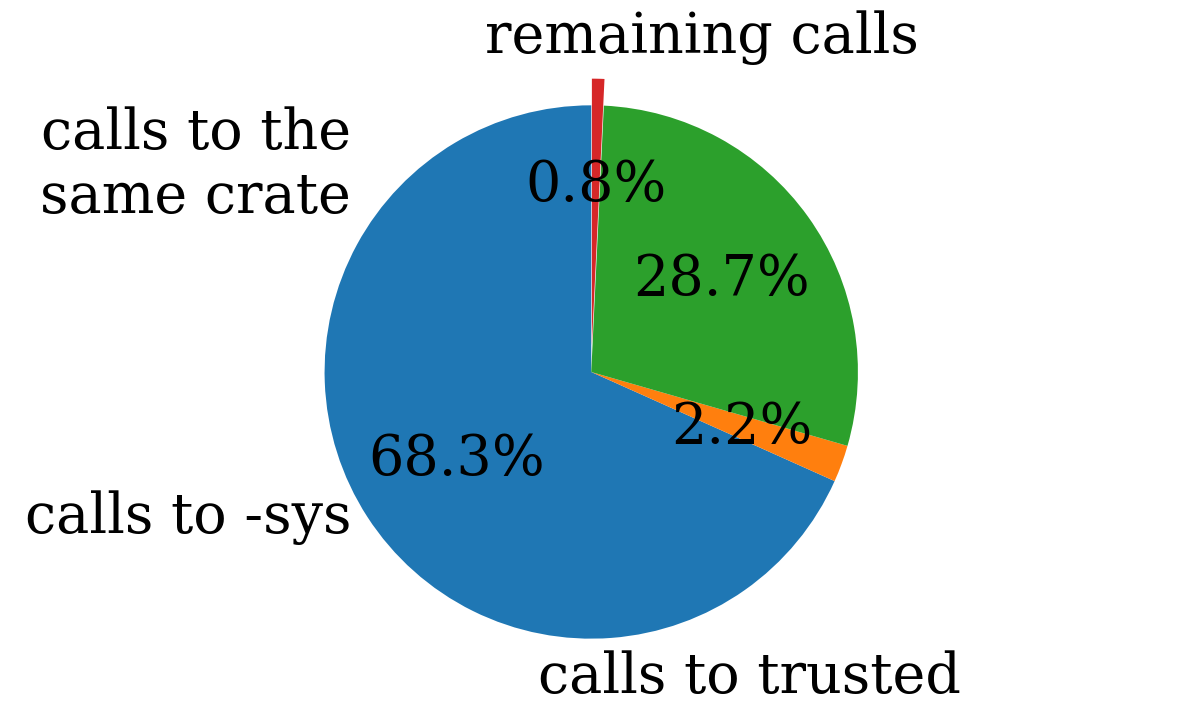

In [67]:
group3 = get_group3(unsafe_block_calls)
categorize_standard_calls(group3)

### Query 4, Case 2

> we use a refined query that counts *how many function calls in unsafe blocks have a call target which is located in (1) its own crate, (2) a crate belonging to the standard library, (3) a -sys crate, or (4) any other crate*.

The first considers only standard function calls of unsafe functions in unsafe blocks.

#### Results from the paper for comparison (Fig. 8)

![Fig. 7](pics/unsafe-calls-from-blocks.png)

Number of calls to standard functions: 6607
Unsafe calls ration: 6607/9960 = 66.3%
Total calls: 6607
         calls to the same crate:    4854
                   calls to -sys:     223
                calls to trusted:    1488
                 remaining calls:      42


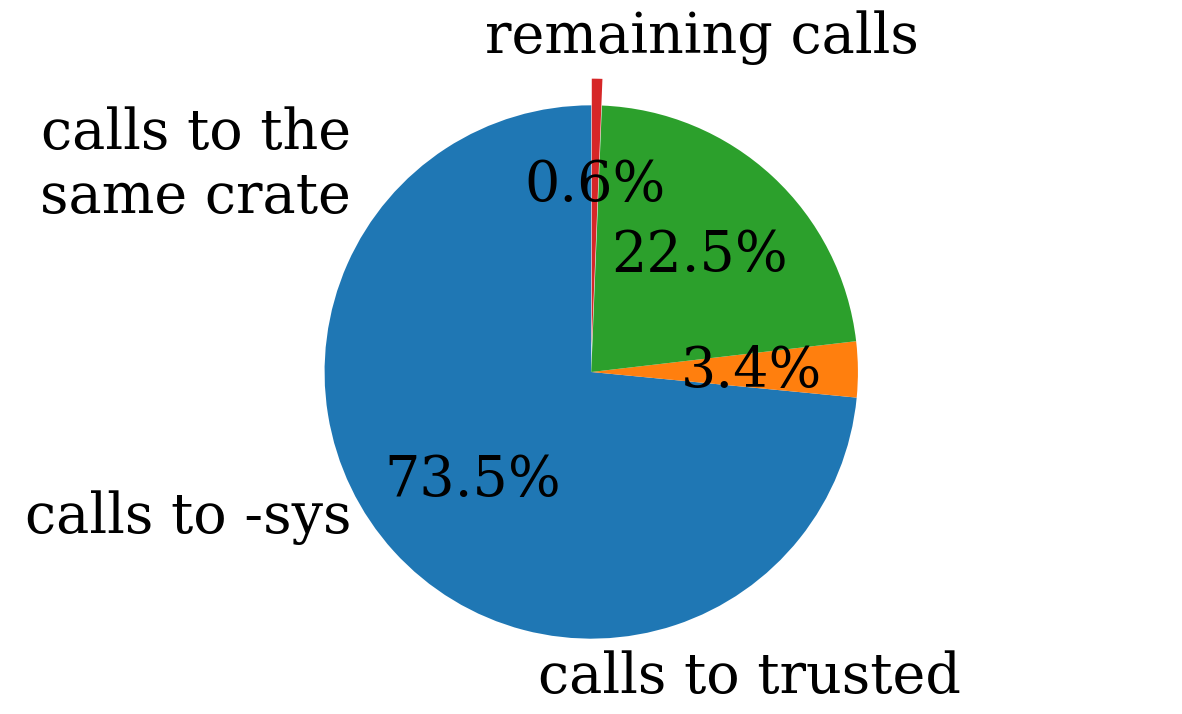

In [68]:
group3_unsafe = get_group3(unsafe_block_calls.query("unsafety == 'Unsafe'"))
info("Unsafe calls ration: {}/{} = {:.1f}%", len(group3_unsafe), len(group3), 100*len(group3_unsafe)/len(group3))
categorize_standard_calls(group3_unsafe)

## Query 5, Case 1

> *we measure how many function calls in unsafe blocks and unsafe functions are (a) standard function calls, (b) calls of trait methods, or (c) calls of closures or function pointers*.

We now consider the aggregated results for the above query with respect to all unsafe blocks.

#### Results from the paper for comparison (Fig. 5)

![Fig. 7](pics/all-calls-from-blocks.png)

Total calls: 11549
  closures and function pointers:      92
                   trait methods:    1497
         standard function calls:    9960


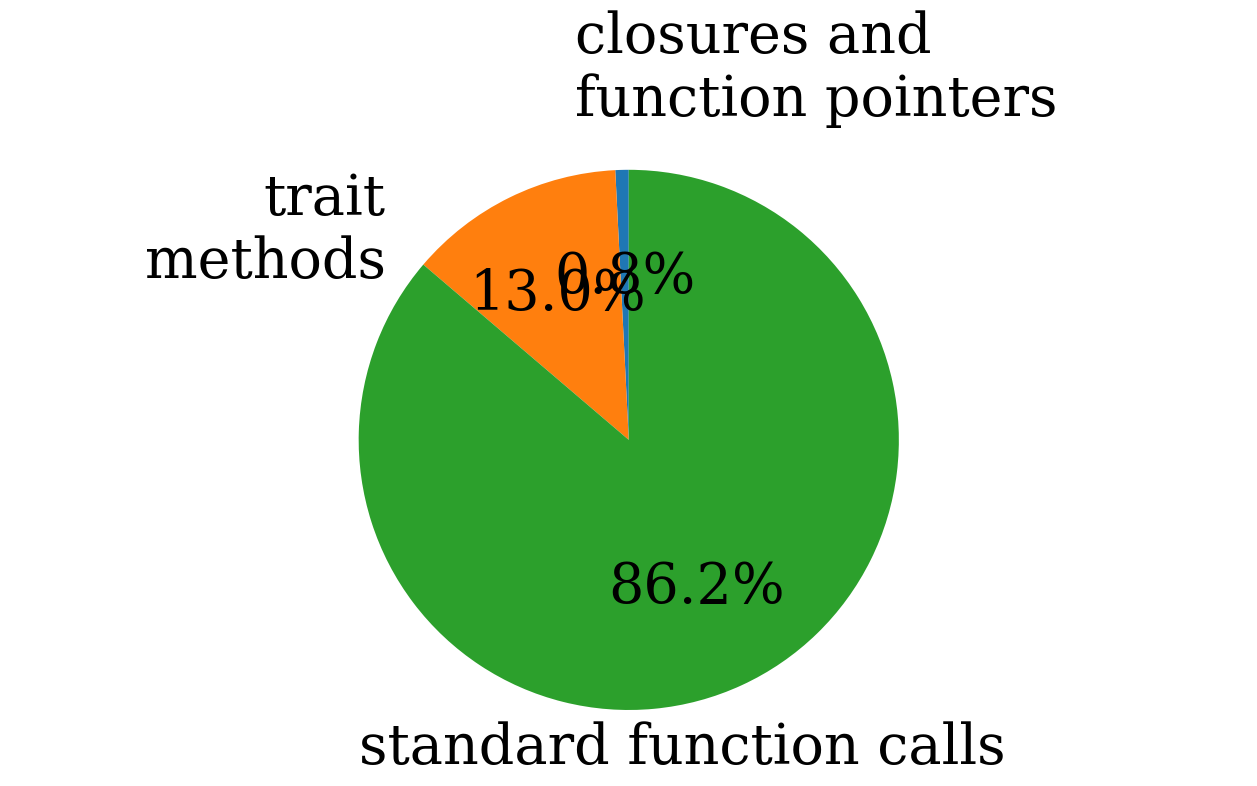

In [69]:
assert len(unsafe_block_calls) == len(group1) + len(group2) + len(group3)

def plot_group_sizes(group1, group2, group3):
    slices = [
        ("closures and function pointers", len(group1)),
        ("trait methods", len(group2)),
        ("standard function calls", len(group3)),
    ]
    labels = [label for (label, _) in slices]
    values = [value for (_, value) in slices]
    info("Total calls: {}", sum(values))
    for (label, count) in slices:
        info("  {:>30s}: {:>7d}", label.replace('\n', ' '), count)
    
    fig1, ax1 = plt.subplots()
    fig1.tight_layout()
    ax1.pie(
        values, #labels=slices.keys(),
        autopct='%1.1f%%', startangle=90,
#         explode=[int("closures and function pointers" in x) * 0.1 for x in labels],
    )
    ax1.text(-1, -1.2, "standard function calls")
    ax1.text(-0.2, 1.2, "closures and\nfunction pointers")
    ax1.text(-0.9, 0.6, "trait\nmethods", horizontalalignment='right')
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
plot_group_sizes(group1, group2, group3)

## Query 5, Case 2

> *we measure how many function calls in unsafe blocks and unsafe functions are (a) standard function calls, (b) calls of trait methods, or (c) calls of closures or function pointers*.

We now consider the aggregated results for the above query with respect to the entire dataset.

#### Results from the paper for comparison (Fig. 6)

![Fig. 7](pics/all-calls.png)

In [70]:
all_calls = utils.load_all_thir_calls()

In [71]:
all_group1 = get_group1(all_calls)

Number of calls to function pointers: 150
Number of calls to Fn closures: 442
Number of calls to FnMut closures: 914
Number of calls to FnOnce closures: 451
Total number of calls to closures: 1807
Total number of calls to function pointers and closures: 1957


In [72]:
all_group2 = get_group2(all_calls)

Number of calls to trait methods: 90587


In [73]:
all_group3 = get_group3(all_calls)

Number of calls to standard functions: 151222


In [74]:
# assert len(all_calls) == len(group1) + len(group2) + len(group3)
len(all_calls)

243764

Total calls: 243766
  closures and function pointers:    1957
                   trait methods:   90587
         standard function calls:  151222


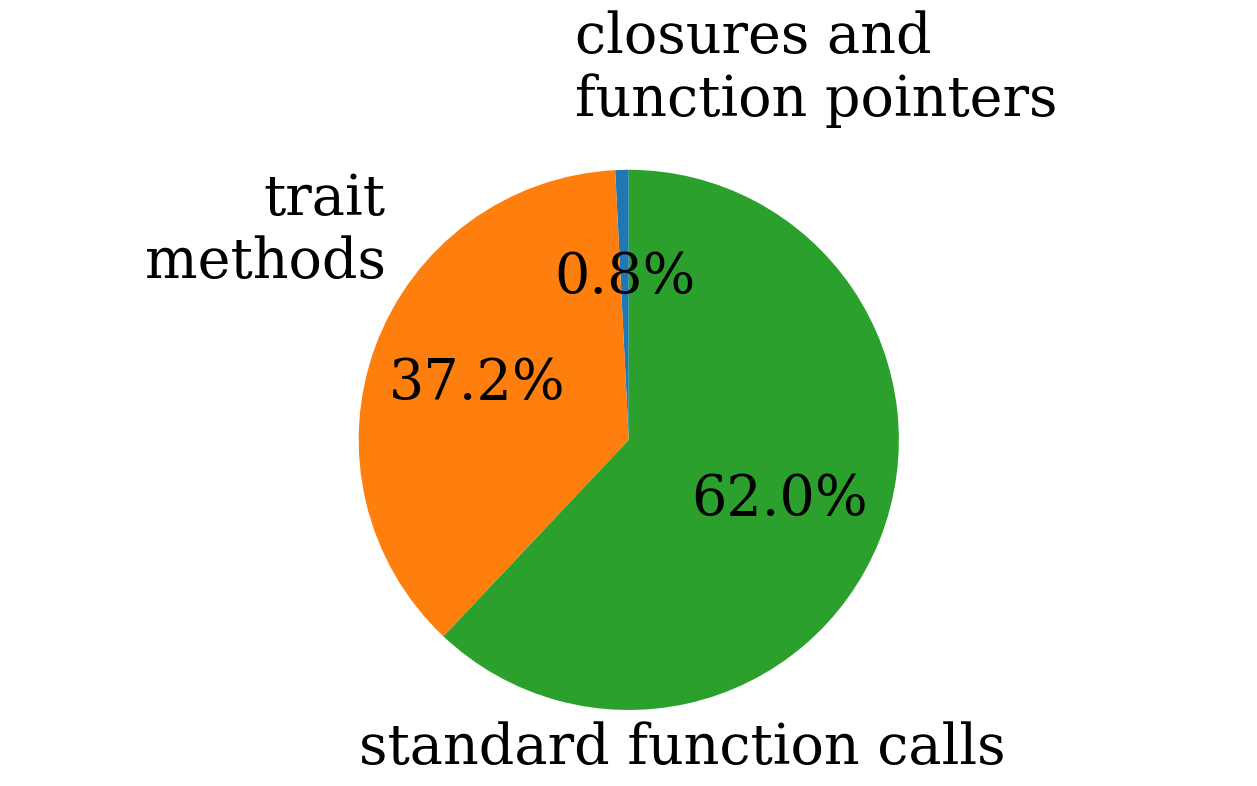

In [75]:
plot_group_sizes(all_group1, all_group2, all_group3)